In [1]:
import utils as local_utils
import torch
import torch.nn as nn
#import pytorch_utils
import torch.optim as optim
import torch.optim as optim
import torch.utils.data as DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import sys
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from importlib import reload
import torch.nn.functional as F
from torchvision import transforms, utils, models
import os, sys
from random import shuffle

%matplotlib inline

In [2]:
USE_GPU = True
IMG_SZ = 224

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


## Custom dataset

In [3]:
class LandmarksDataset(DataLoader.Dataset):

    def __init__(self, src_folder, transform=None):
        """
        Args:
            src_folder (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.filenames = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f)) 
                          and f != '.DS_Store']
        self.src_folder = src_folder
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.src_folder, self.filenames[idx])
        
        x = Image.open(img_name)

        if self.transform:
            x = self.transform(x)

        imgf = self.filenames[idx]
        y = int(imgf[imgf.index('_') + 1 : imgf.index('.')]) # filename format: [id_label.jpg]
        sample = (x, y)
        return sample

In [4]:
def get_loader(directory, batch_size, img_sz=None):
    '''
    takes in directory for train and val data, and returns loaders for both
    applies normalization:
      1. convert values to range 0-1
      2. set mean, std to those specified in pytorch pretrained models (https://pytorch.org/docs/master/torchvision/models.html)
    
    usage:
        loader_train = get_loader(train_directory, batch_sz)
        loader_val = get_loader(val_directory, batch_sz)
    '''
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])

    if img_sz == None:
        preprocess = transforms.Compose([
            transforms.ToTensor(),  # converts to range 0-1
            normalize               # sets mean, std
        ])
    else:
        preprocess = transforms.Compose([
            transforms.Resize((IMG_SZ, IMG_SZ)), # resize img (ie, for Inception)
            transforms.ToTensor(),  # converts to range 0-1
            normalize               # sets mean, std
        ])
    
    dset = LandmarksDataset(directory, transform=preprocess)
    loader = DataLoader.DataLoader(dataset=dset, batch_size=batch_size)
    
    print ('dataset size', len(dset))
    return loader

## Training and accuracy checking

In [5]:
def check_accuracy(loader, model): 
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc

In [6]:
def train(model, optimizer, loader_train, epochs=1, stop=1):
    """
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    iters = []
    losses = []
    for e in range(epochs):
        print ('epoch', e)
        
        num_iters = len(loader_train)
        want_print = 10
        print_every = 50
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
        
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print(' Iteration %d out of %d, loss = %.4f' % (t, num_iters, loss.item()))
                iters.append(t)
                losses.append(loss.item())
            
            # break early if we only want to use a part of the dataset (for hyperparameter tuning)
            if t > stop * num_iters:
                break

    return iters, losses

## Plotting

In [7]:
def plot_loss_data(plotting_data, title_str):
    '''
    Plots all loss curves for hyperparameter tuning runs.
    Plots loss vs. iterations.
    '''
    for plot_data in plotting_data:
        iters, losses, label = plot_data        
        plt.plot(iters, losses, label=label)
    plt.title(title_str)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.legend(loc=(1.1, 0.25))
    
    # set figsize
    plt.rcParams["figure.figsize"] = (9, 6)
    
    plt.plot()

In [8]:
def plot_loss_data_v2(plotting_data, title_str):
    '''
    Plots all loss curves for hyperparameter tuning runs
    This version plots loss vs. percent of iterations complete. This means
    each run has the same x distance on the graph.
    '''
    max_n = max([len(iters) for iters, _, _ in plotting_data])
    
    for plot_data in plotting_data:
        iters, losses, label = plot_data 
        n = len(losses)
        
        # need to go between 0 and max_n, with n entries
        dist = (max_n - 1) / (n-1)
        x = [e * dist for e in range(n)]
        x_max = max(x)
        x = [e / x_max for e in x] # normalize to 0 - 1
                
        plt.plot(x, losses, label=label)
        
    plt.title(title_str)
    plt.xlabel('Fraction of tuning run elapsed')
    plt.ylabel('Loss')
    plt.legend(loc=(1.1, 0.25))
    
    plt.rcParams["figure.figsize"] = (9, 6) # set figsize
    plt.plot()

In [9]:
def plot_single_loss(iters, losses, title_str):
    plt.plot(iters, losses)
    plt.title(title_str)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    
    # set figsize
    plt.rcParams["figure.figsize"] = (9, 6)
    
    plt.plot()

# Models!

### Resnet

In [ ]:
# referenced https://www.kaggle.com/gntoni/using-pytorch-resnet

# hyperparam tuning on lr and batch sz
lr_vals = [0.0001, 0.001, 0.01]
batch_sizes = [10, 20, 50, 80]

train_directory = '../data/data_200c/train'
val_directory = '../data/data_200c/val'

momentum = 0.9
num_classes = 200

best_lr = None
best_batch_size = None
best_model = None
best_loss = float('inf')
plotting_data = []

for batch_size in batch_sizes:
    loader_train = get_loader(train_directory, batch_size)
    for lr in lr_vals:
        # set up resnet model with custom FC layer to predict our number of classes
        model = models.resnet18(pretrained=True)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, num_classes)
        
        # Observe that all parameters are being optimized
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        num_epochs = 1
        iters, losses = train(model, optimizer, loader_train, num_epochs, 0.20) # stopping early to save time
        
        s = 'lr: %f, batch sz: %d' % (lr, batch_size)
        plotting_data.append((iters, losses, s))
        
        final_loss = losses[-1]
        print('got a loss of ', final_loss, ' for parameters ', 'batch size: ', batch_size, ' lr: ', lr)
        if final_loss < best_loss:
            best_loss = final_loss
            best_model = model
            best_lr = lr
            best_batch_size = batch_size
            
print("best values ", best_loss, best_lr, best_batch_size)

Check accuracies

In [ ]:
loader_val = get_loader(val_directory, best_batch_size)
print ('validation accuracy is ', check_accuracy(loader_val, best_model))
loader_train = get_loader(train_directory, best_batch_size)
print ('training accuracy is ', check_accuracy(loader_train, best_model))

Plot loss curves

In [ ]:
plot_data(plotting_data, title_str="Hyperparameter tuning for Resnet18")

In [ ]:
plot_loss_data_v2(plotting_data, title_str="Hyperparameter tuning for Resnet18")

### Squeezenet

In [73]:
# hyperparam tuning on lr and batch sz
lr_vals = [0.0001, 0.001, 0.01]
batch_sizes = [10, 20, 50, 80]

train_directory = '../data/data_200c/train'
val_directory = '../data/data_200c/val'

# for testing
# train_directory = '../data/data_200c/mini'
# val_directory = '../data/data_200c/mini'
# batch_sizes = [1, 2, 5, 8]

momentum = 0.9
num_classes = 200

best_lr = None
best_batch_size = None
best_model = None
best_loss = float('inf')
plotting_data = []

for batch_size in batch_sizes:
    loader_train = get_loader(train_directory, batch_size)
    for lr in lr_vals:
        # set up squeezenet model with custom final conv layer to predict our number of classes
        model = models.squeezenet1_0(pretrained=True)
        final_conv = nn.Conv2d(512, num_classes, kernel_size=1)
        model.num_classes = num_classes
        model.classifier = nn.Sequential(
                    nn.Dropout(p=0.5),
                    final_conv,
                    nn.ReLU(inplace=True),
                    nn.AvgPool2d(13))
        
        # Observe that all parameters are being optimized
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        num_epochs = 1
        iters, losses = train(model, optimizer, loader_train, num_epochs, 0.20) # stopping early to save time
        
        s = 'lr: %f, batch sz: %d' % (lr, batch_size)
        plotting_data.append((iters, losses, s))
        
        final_loss = losses[-1]
        print('got a loss of ', final_loss, ' for parameters ', 'batch size: ', batch_size, ' lr: ', lr)
        if final_loss < best_loss:
            best_loss = final_loss
            best_model = model
            best_lr = lr
            best_batch_size = batch_size
print (' ')          
print("best loss: ", best_loss, 'best lr', best_lr, 'best batch sz', best_batch_size)

dataset size 30397
epoch 0


/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


 Iteration 0 out of 3040, loss = 5.9085
 Iteration 50 out of 3040, loss = 5.3245
 Iteration 100 out of 3040, loss = 5.1847
 Iteration 150 out of 3040, loss = 5.2628
 Iteration 200 out of 3040, loss = 5.3581
 Iteration 250 out of 3040, loss = 5.2428
 Iteration 300 out of 3040, loss = 5.3100
 Iteration 350 out of 3040, loss = 5.3848
 Iteration 400 out of 3040, loss = 5.2091
 Iteration 450 out of 3040, loss = 5.3631
 Iteration 500 out of 3040, loss = 5.2029
 Iteration 550 out of 3040, loss = 5.3012
 Iteration 600 out of 3040, loss = 5.1650
got a loss of  5.165042877197266  for parameters  batch size:  10  lr:  0.0001
epoch 0
 Iteration 0 out of 3040, loss = 5.8803
 Iteration 50 out of 3040, loss = 5.2405
 Iteration 100 out of 3040, loss = 5.2906
 Iteration 150 out of 3040, loss = 5.3688
 Iteration 200 out of 3040, loss = 5.2060
 Iteration 250 out of 3040, loss = 5.3079
 Iteration 300 out of 3040, loss = 5.2675
 Iteration 350 out of 3040, loss = 5.0925
 Iteration 400 out of 3040, loss = 5.

Plot loss curves for hyperparam tuning

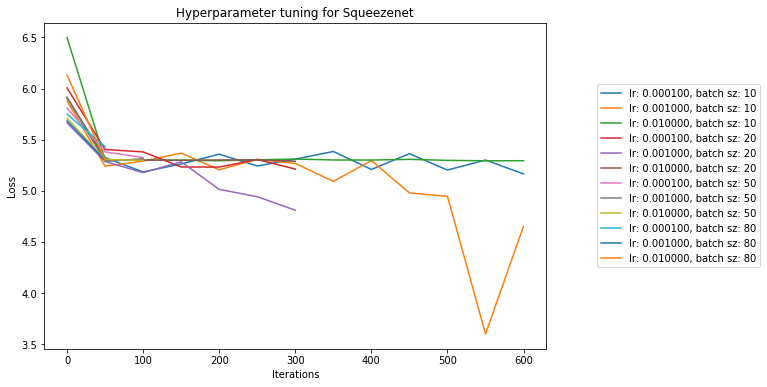

In [78]:
plot_loss_data(plotting_data, title_str="Hyperparameter tuning for Squeezenet")

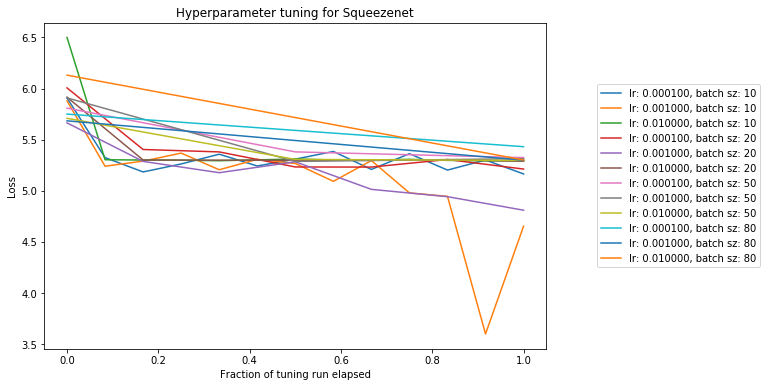

In [79]:
plot_loss_data_v2(plotting_data, title_str="Hyperparameter tuning for Squeezenet")

Train best model for full epoch, get final val & train accuracy, plot loss curve

In [80]:
# use best_lr, best_batch_size
lr = best_lr
batch_size = best_batch_size

# load data
loader_val = get_loader(val_directory, batch_size)
loader_train = get_loader(train_directory, batch_size)

# set up squeezenet model with custom final conv layer to predict our number of classes
model = models.squeezenet1_0(pretrained=True)
final_conv = nn.Conv2d(512, num_classes, kernel_size=1)
model.num_classes = num_classes
model.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            final_conv,
            nn.ReLU(inplace=True),
            nn.AvgPool2d(13))

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# run for full epoch
num_epochs = 1
iters, losses = train(model, optimizer, loader_train, num_epochs)

dataset size 7549
dataset size 30397


/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/models/squeezenet.py:94: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
/home/shared/anaconda3/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/models/squeezenet.py:92: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


epoch 0
 Iteration 0 out of 3040, loss = 5.4372
 Iteration 50 out of 3040, loss = 5.2705
 Iteration 100 out of 3040, loss = 5.3125
 Iteration 150 out of 3040, loss = 5.2952
 Iteration 200 out of 3040, loss = 5.2546
 Iteration 250 out of 3040, loss = 5.3238
 Iteration 300 out of 3040, loss = 5.2486
 Iteration 350 out of 3040, loss = 5.3044
 Iteration 400 out of 3040, loss = 5.3199
 Iteration 450 out of 3040, loss = 5.1399
 Iteration 500 out of 3040, loss = 5.2331
 Iteration 550 out of 3040, loss = 4.7022
 Iteration 600 out of 3040, loss = 4.8165
 Iteration 650 out of 3040, loss = 5.1082
 Iteration 700 out of 3040, loss = 4.2731
 Iteration 750 out of 3040, loss = 5.0459
 Iteration 800 out of 3040, loss = 4.2527
 Iteration 850 out of 3040, loss = 3.4434
 Iteration 900 out of 3040, loss = 2.8775
 Iteration 950 out of 3040, loss = 4.3053
 Iteration 1000 out of 3040, loss = 2.7273
 Iteration 1050 out of 3040, loss = 2.6277
 Iteration 1100 out of 3040, loss = 2.6130
 Iteration 1150 out of 304

NameError: name 'plot_single_loss' is not defined

In [81]:
# get final accuracies
print ('validation accuracy is ', check_accuracy(loader_val, model))
print ('training accuracy is ', check_accuracy(loader_train, model))

# plot loss for fully trained best model
plot_single_loss(iters, losses, 'Loss for tuned Squeezenet model')

Got 4804 / 7549 correct (63.64)
validation accuracy is  0.6363756788978673
Got 19926 / 30397 correct (65.55)
training accuracy is  0.6555252163042405


NameError: name 'plot_single_loss' is not defined

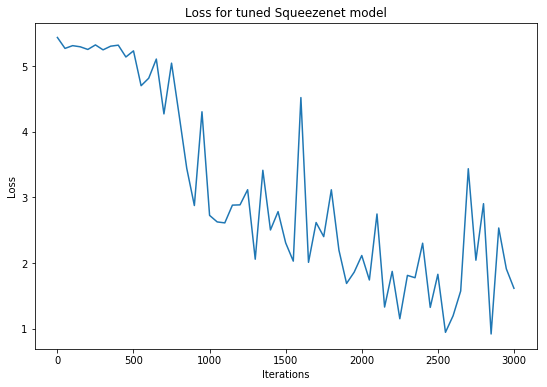

In [83]:
# plot loss for fully trained best model
plot_single_loss(iters, losses, 'Loss for tuned Squeezenet model')

### Inception

In [ ]:
# hyperparam tuning on lr and batch sz
lr_vals = [0.0001, 0.001, 0.01]
batch_sizes = [10, 20, 50, 80]

train_directory = '../data/data_200c/train'
val_directory = '../data/data_200c/val'
IMG_SZ = 299 # inception takes in 299 x 299 rather than 224 x 224


# for testing
# train_directory = '../data/data_200c/mini'
# val_directory = '../data/data_200c/mini'
# batch_sizes = [2, 5]

momentum = 0.9
num_classes = 200

best_lr = None
best_batch_size = None
best_model = None
best_loss = float('inf')
plotting_data = []

for batch_size in batch_sizes:
    loader_train = get_loader(train_directory, batch_size, img_sz=IMG_SZ)
    for lr in lr_vals:
        # set up inception model with custom final FC layer to predict our number of classes
        model = models.inception_v3(pretrained=True)
        model.aux_logits=False
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)
        
        # Observe that all parameters are being optimized
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        num_epochs = 1
        iters, losses = train(model, optimizer, loader_train, num_epochs, 0.20) # stopping early to save time
        
        s = 'lr: %f, batch sz: %d' % (lr, batch_size)
        plotting_data.append((iters, losses, s))
        
        final_loss = losses[-1]
        print('got a loss of ', final_loss, ' for parameters ', 'batch size: ', batch_size, ' lr: ', lr)
        if final_loss < best_loss:
            best_loss = final_loss
            best_model = model
            best_lr = lr
            best_batch_size = batch_size
print (' ')          
print("best loss: ", best_loss, 'best lr', best_lr, 'best batch sz', best_batch_size)

dataset size 30397
epoch 0
 Iteration 0 out of 3040, loss = 5.3754
 Iteration 50 out of 3040, loss = 5.1427
 Iteration 100 out of 3040, loss = 5.3375
 Iteration 150 out of 3040, loss = 5.3977
 Iteration 200 out of 3040, loss = 5.2608
 Iteration 250 out of 3040, loss = 5.2212
 Iteration 300 out of 3040, loss = 5.3307
 Iteration 350 out of 3040, loss = 5.2404
 Iteration 400 out of 3040, loss = 5.2522
 Iteration 450 out of 3040, loss = 5.1946
 Iteration 500 out of 3040, loss = 5.2998
 Iteration 550 out of 3040, loss = 5.1555
 Iteration 600 out of 3040, loss = 5.2777
got a loss of  5.277733325958252  for parameters  batch size:  10  lr:  0.0001
epoch 0
 Iteration 0 out of 3040, loss = 5.3341
 Iteration 50 out of 3040, loss = 5.2576
 Iteration 100 out of 3040, loss = 5.2928
 Iteration 150 out of 3040, loss = 5.3194
 Iteration 200 out of 3040, loss = 5.0889
 Iteration 250 out of 3040, loss = 5.2775
 Iteration 300 out of 3040, loss = 4.9019
 Iteration 350 out of 3040, loss = 4.8038
 Iteration

Plot loss curves for hyperparam tuning

In [10]:
# hardcode losses from output bc kernel crashed...

plotting_data = [([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600], [5.3754, 5.1427, 5.3375, 5.3977, 5.2608, 5.2212, 5.3307, 5.2404, 5.2522, 5.1946, 5.2998, 5.1555, 5.2777], 'lr: 0.000100, batch sz: 10'), ([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600], [5.3341, 5.2576, 5.2928, 5.3194, 5.0889, 5.2775, 4.9019, 4.8038, 4.7258, 4.5528, 4.7959, 3.5922, 4.0433], 'lr: 0.001000, batch sz: 10'), ([0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600], [5.5302, 5.1722, 5.3246, 5.3558, 5.269, 5.3565, 5.2771, 5.1424, 4.7403, 5.151, 4.5263, 3.7522, 4.3695], 'lr: 0.010000, batch sz: 10'), ([0, 50, 100, 150, 200, 250, 300], [5.4148, 5.2692, 5.341, 5.3893, 5.4452, 5.382, 5.255], 'lr: 0.000100, batch sz: 20'), ([0, 50, 100, 150, 200, 250, 300], [5.3246, 5.2334, 5.1394, 5.1029, 4.9895, 4.9006, 4.673], 'lr: 0.001000, batch sz: 20'), ([0, 50, 100, 150, 200, 250, 300], [5.2626, 5.1037, 4.2652, 3.7401, 3.1108, 2.1527, 2.3826], 'lr: 0.010000, batch sz: 20'), ([0, 50, 100], [5.3444, 5.3148, 5.3513], 'lr: 0.000100, batch sz: 50'), ([0, 50, 100], [5.3758, 5.3234, 5.1829], 'lr: 0.001000, batch sz: 50'), ([0, 50, 100], [5.3524, 4.3342, 2.6445], 'lr: 0.010000, batch sz: 50'), ([0, 50], [5.3382, 5.341], 'lr: 0.000100, batch sz: 80'), ([0, 50], [5.3482, 5.2761], 'lr: 0.001000, batch sz: 80'), ([0, 50], [5.3604, 4.3792], 'lr: 0.010000, batch sz: 80')]


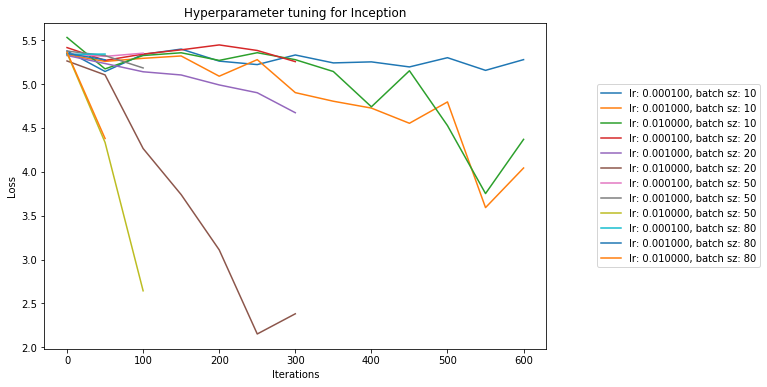

In [13]:
plot_loss_data(plotting_data, title_str="Hyperparameter tuning for Inception")

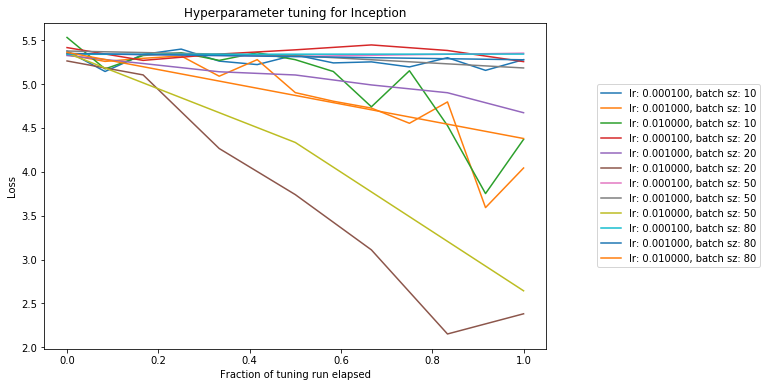

In [14]:
plot_loss_data_v2(plotting_data, title_str="Hyperparameter tuning for Inception")

Train best model for full epoch, get final val & train accuracy, plot loss curve

In [12]:
# use best_lr, best_batch_size
#lr = best_lr
#batch_size = best_batch_size
lr = 0.01        # best lr
batch_size = 20  # best batch size

train_directory = '../data/data_200c/train'
val_directory = '../data/data_200c/val'
IMG_SZ = 299 # inception takes in 299 x 299 rather than 224 x 224

momentum = 0.9
num_classes = 200

# load data
loader_val = get_loader(val_directory, batch_size, img_sz=IMG_SZ)
loader_train = get_loader(train_directory, batch_size, img_sz=IMG_SZ)

# set up inception model with custom final FC layer to predict our number of classes
model = models.inception_v3(pretrained=True)
model.aux_logits=False
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# run for full epoch
num_epochs = 1
iters, losses = train(model, optimizer, loader_train, num_epochs)

dataset size 7549
dataset size 30397
epoch 0
 Iteration 0 out of 1520, loss = 5.4399
 Iteration 50 out of 1520, loss = 4.9879
 Iteration 100 out of 1520, loss = 4.0618
 Iteration 150 out of 1520, loss = 3.7810
 Iteration 200 out of 1520, loss = 2.5721
 Iteration 250 out of 1520, loss = 1.8988
 Iteration 300 out of 1520, loss = 2.2166
 Iteration 350 out of 1520, loss = 1.9703
 Iteration 400 out of 1520, loss = 2.1951
 Iteration 450 out of 1520, loss = 1.5547
 Iteration 500 out of 1520, loss = 1.0997
 Iteration 550 out of 1520, loss = 1.3954
 Iteration 600 out of 1520, loss = 1.7192
 Iteration 650 out of 1520, loss = 1.1169
 Iteration 700 out of 1520, loss = 1.2291
 Iteration 750 out of 1520, loss = 1.2041
 Iteration 800 out of 1520, loss = 1.9303
 Iteration 850 out of 1520, loss = 1.0902
 Iteration 900 out of 1520, loss = 1.2868
 Iteration 950 out of 1520, loss = 1.5144
 Iteration 1000 out of 1520, loss = 1.2350
 Iteration 1050 out of 1520, loss = 1.2575
 Iteration 1100 out of 1520, los

In [13]:
# get final accuracies
print ('validation accuracy is ', check_accuracy(loader_val, model))
print ('training accuracy is ', check_accuracy(loader_train, model))

Got 5939 / 7549 correct (78.67)
validation accuracy is  0.7867267187706981
Got 25003 / 30397 correct (82.25)
training accuracy is  0.8225482777905715


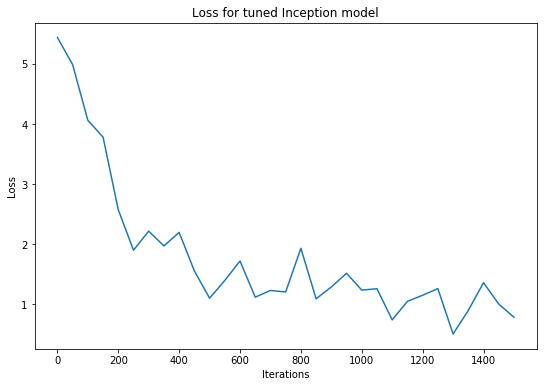

In [15]:
# plot loss for fully trained best model
plot_single_loss(iters, losses, 'Loss for tuned Inception model')